# Define Environment Variables

In [7]:
import os
os.environ["OLLAMA_BASE_URL"] = "http://localhost:11434"

# Initialize Ollama Chatbot

In [10]:
from langchain_ollama import ChatOllama

# minimize randomness for reproducibility
seed = 42
temperature = 0

# Set up the Ollama chat model with specified parameters
llm = ChatOllama(
    base_url=os.environ["OLLAMA_BASE_URL"],
    model="mistral",
    temperature=temperature,
    seed=seed,
)

# Chat Demo

In [1]:
from langchain.schema import AIMessage, HumanMessage, SystemMessage
stop = False
history = []
while not stop:
    # input a user prompt
    prompt = input()
    # create a human message
    human_message = HumanMessage(content=prompt)
    # pretty print the human message
    human_message.pretty_print()
    # add it to the chat history
    history.append(request)
    # generate an IA message given chat history
    ai_message = llm.invoke(history)
    # pretty print the IA message
    response.pretty_print()
    # add it to the chat history
    history.append(response)
    break


================================ Human Message =================================

test


NameError: name 'request' is not defined

# React
- 0. Audio Recorder
- 1. Speech-To-Text Ai
- 2. Text-To-Speech AI + Text-To-Api tools
- 3. CairnFORM driver

In [ ]:
!pip install langchain==0.3.25 langchain-core==0.3.59
!pip install urllib3==2.4.0
!pip install transformers==4.51.3

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
/usr/share/python-wheels/toml-0.10.0-py2.py3-none-any.whl/toml/decoder.py:47: SyntaxWarning: invalid escape sequence '\.'
/usr/share/python-wheels/toml-0.10.0-py2.py3-none-any.whl/toml/decoder.py:47: SyntaxWarning: invalid escape sequence '\.'
Traceback (most recent call last):
  File "/bin/pip", line 11, in <module>
    load_entry_point('pip==20.0.2', 'console_scripts', 'pip')()
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.13/dist-packages/pkg_resources/__init__.py", line 535, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/usr/local/lib/python3.13/dist-packages/pkg_resources/__init__.py", line 3208, in load_entry_point
    return ep.load()
           ~~~~~~

In [ ]:
import os
# from langfuse import Langfuse
os.environ["LANGFUSE_PUBLIC_KEY"] = "lf_pk_1234567819"
os.environ["LANGFUSE_SECRET_KEY"] = "lf_sk_1234567819"
os.environ["LANGFUSE_HOST"] = "http://82.64.250.105:3333"
os.environ["NINJA_API_KEY"] = 'MdaCcVUHseixkwpNGhumWg==9mb676ZThl4du9aP'
os.environ["COINDESK_API_KEY"] = 'f878a7c1f81bae5b40dbae9478393a7c51cb2df86856d29de6d8a0ade023e9de'
os.environ["OLLAMA_BASE_URL"] = "http://localhost:11434"
os.environ["LLM_CONTEXT_WINDOW"] = "32768"
from langchain_core.callbacks.manager import CallbackManager
print("Import works!")
# langfuse = Langfuse()
# assert langfuse.auth_check() == True, "Langfuse authentication failed. Please check your keys and host."

Import works!


# Define Tools

In [ ]:
from langchain_core.tools import tool, Tool
from matplotlib import pyplot as plt
from pydantic import BaseModel, Field
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description_and_args
from langchain.agents import AgentType, AgentExecutor, initialize_agent, create_react_agent, create_tool_calling_agent, create_openai_tools_agent
import langgraph.prebuilt
from langchain_ollama import ChatOllama
from langchain_core.tools.render import render_text_description
import requests
import ast
from geopy.geocoders import Nominatim
from datetime import datetime
import time
from langchain import hub
from langchain.globals import set_verbose, set_debug
from py_mini_racer import py_mini_racer
import io
import contextlib
from math import ceil
from copy import deepcopy
import json
from datetime import timedelta
import matplotlib.pyplot as pl
import numpy as np
from matplotlib.collections import LineCollection
import uuid
 
set_verbose(True)
set_debug(False)


def generate_uuid():
    return str(uuid.uuid4())



# ============================================================
# Define a custom but dummy tool
# ============================================================
class LatitudeAndLongitudeInput(BaseModel):
    location: str = Field(description="location to search for")

@tool(args_schema=LatitudeAndLongitudeInput)
def get_latitude_and_longitude(location: str) -> dict:
        """Returns the latitude and longitude coordinates for a given location."""
        geolocator = Nominatim(user_agent='myapplication')
        results = geolocator.geocode(location)
        if results is None:
            #print("Error: No results found")
            return None
        # print(results.latitude, results.longitude)
        return {
            "latitude": results.latitude,
            "longitude": results.longitude
        }

# class LiveCommodityPriceInput(BaseModel):
#     commodities: list[str] = Field(description="List of commodities to search for. Accepted values are: 'gold', 'platinum', 'lean_hogs', 'oat', 'aluminium', 'soybean_meal', 'lumber', 'micro_gold', 'feeder_cattle', 'rough_rice', 'palladium'.")

# @tool(args_schema=LiveCommodityPriceInput)
# def get_live_commodity_price(commodities: list[str]) -> str:
#     """Returns live price of commodities."""
#     ans = []
#     for commodity in commodities:
#         api_url = f'https://api.api-ninjas.com/v1/commodityprice?name={commodity}'

#         response = requests.get(api_url, headers={'X-Api-Key': os.environ["NINJA_API_KEY"]})
#         if response.status_code == requests.codes.ok:
#             dict_response = ast.literal_eval(response.text)
#             commodity_price_dict = {'commodity': commodity, 'price': dict_response['price'], 'datetime': datetime.fromtimestamp(dict_response['updated']).isoformat()}
#             ans.append(commodity_price_dict)
#     return ans

# res = get_live_commodity_price.invoke({'commodities':["gold", "oat"]})
# print(res)

## CRYPTOCURRENCY -> https://developers.coindesk.com/documentation/data-api/spot_v1_latest_tick (COINDESK)
class HistoricalCryptoPriceInput(BaseModel):
    pairs: list[str] = Field(description="List of cryptocurrency pairs to search for. Accepted values are: 'BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD', 'DOGE-USD', 'SOL-USD', 'DOT-USD', 'LINK-USD', 'MATIC-USD'.")
    interval: str = Field(default=1, description="Time interval between prices. Accepted values are: 'days', 'hours', 'minutes'.")
    size: int = Field(default=1, description="Number of prices to return.")

@tool(args_schema=HistoricalCryptoPriceInput)
def get_historical_crypto_price(pairs: list[str], interval:str, size:int) -> str:
    """Returns historical price of cryptocurrencies."""
    ans = []
    api_url =f'https://data-api.coindesk.com/spot/v1/historical/{interval}'
    #response = requests.get(api_url, headers={'X-Api-Key': os.environ["COINDESK_API_KEY"]})
    for pair in pairs:
        response = requests.get(api_url,
            params={"instrument":pair,
                    "apply_mapping":"true",
                    "fill":"true",
                    "aggregate":1,
                    "market":"coinbase",
                    "limit":size,
                    "response_format":"JSON",
                    "api_key":os.environ["COINDESK_API_KEY"]},
            headers={"Content-type":"application/json; charset=UTF-8"}
        )
        if response.status_code == requests.codes.ok:
            dict_response = ast.literal_eval(response.text)
            hist_crypto_price_dict = {"pair": pair, 'prices': []}

            for i in range(len(dict_response['Data'])):
                data_point = dict_response['Data'][i]
                price_dict = {
                    'datetime': datetime.fromtimestamp(data_point['TIMESTAMP']).isoformat(),
                    'open': data_point['OPEN'],
                    'high': data_point['HIGH'],
                    'low': data_point['LOW'],
                    'close': data_point['CLOSE'],
                }
                hist_crypto_price_dict['prices'].append(price_dict)
            ans.append(hist_crypto_price_dict)
    ans = json.dumps(ans, indent=2) # for pretty print
    return str(ans)

# res = get_historical_crypto_price.invoke({'pairs':["BTC-USD", "ETH-USD"], 'interval':'days', 'size':5})
# print(res)


class LiveCryptoPriceInput(BaseModel):
    pairs: list[str] = Field(description="List of cryptocurrency pairs to search for. Accepted values are: 'BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD', 'DOGE-USD', 'SOL-USD', 'DOT-USD', 'LINK-USD', 'MATIC-USD'.")




@tool(args_schema=LiveCryptoPriceInput)
def get_live_crypto_price(pairs: list[str]) -> str:
    """Returns live price of cryptocurrencies."""
    ans = []
    api_url ='https://data-api.coindesk.com/spot/v1/latest/tick'
    #response = requests.get(api_url, headers={'X-Api-Key': os.environ["COINDESK_API_KEY"]})
    response = requests.get(api_url,
        params={"instruments":','.join(pairs),
                "apply_mapping":"true",
                "market":"coinbase",
                "api_key":os.environ["COINDESK_API_KEY"]},
        headers={"Content-type":"application/json; charset=UTF-8"}
    )
    if response.status_code == requests.codes.ok:
        dict_response = ast.literal_eval(response.text)
        for pair in pairs:
            if pair in dict_response['Data']:
                pair_data = dict_response['Data'][pair]
                pair_price_dict = {
                    'pair': pair,
                    'price': pair_data['PRICE'],
                    'datetime': datetime.fromtimestamp(pair_data['PRICE_LAST_UPDATE_TS']).isoformat()
                }
                ans.append(pair_price_dict)
    return str(ans)

# res = get_live_crypto_price.invoke({'pairs':["BTC-USD", "ETH-USD"]})
# print(res)

class ForecastWeatherInput(BaseModel):
    locations: list[str] = Field(description="List of locations to search for.")
    metrics: list[str] = Field(description="List of weather metrics to search for. Accepted values are: 'temperature_degrees', 'humidity_percentage', 'wind_speed', 'cloud_percentage'.")
    days: int = Field(default=5, description="Number of days to forecast. Maximum is 5 days.")

@tool(args_schema=ForecastWeatherInput)
def get_weather_forecast(locations: list[str], metrics:list[str], days:int) -> str:
    """Returns a 5-day weather forecast (tomorrow, day after tomorrow, etc.) in 3-hour intervals for a given location, including temperature degrees, humidity percentage, wind speed, and cloud percentage."""
    metrics.append('timestamp')
    geolocator = Nominatim(user_agent='myapplication')
    
    ans = []
    for location in locations:
        #current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        curr_datetime = datetime.now().replace(microsecond=0)
        max_datetime = datetime.now() + timedelta(days=days)
        current_datetime = curr_datetime.isoformat()
        location_metrics = {'location': location, 'datetime':current_datetime, 'metrics': None}
        results = geolocator.geocode(location)
        if results is None:
            print("Error: No results found")
            return None
        latitude = results.latitude
        longitude = results.longitude
        api_url = f'https://api.api-ninjas.com/v1/weatherforecast?lat={latitude}&lon={longitude}'
        response = requests.get(api_url, headers={'X-Api-Key': os.environ["NINJA_API_KEY"]})
        if response.status_code == requests.codes.ok:
            dict_responses = ast.literal_eval(response.text)
            new_dict_responses = []
            for i in range(len(dict_responses)):
                #dict_responses[i]['timestamp'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(dict_responses[i]['timestamp']))
                t = datetime.fromtimestamp(dict_responses[i]['timestamp'])
                if t < max_datetime:
                    metrics_dict = {}
                    metrics_dict['timestamp'] = t.isoformat()
                    metrics_dict['temperature_degrees'] = dict_responses[i]['temp']
                    metrics_dict['humidity_percentage'] = dict_responses[i]['humidity']
                    metrics_dict['wind_speed'] = dict_responses[i]['wind_speed']
                    metrics_dict['cloud_percentage'] = dict_responses[i]['cloud_pct']
                    for key in list(metrics_dict):
                        if key not in metrics:
                            del metrics_dict[key]
                new_dict_responses.append(metrics_dict)
            location_metrics['metrics'] =  new_dict_responses
        ans.append(location_metrics)
    return str(ans)

# res = get_weather_forecast.invoke({'locations':["Paris", "Bordeaux"], 'metrics':['temperature_degrees', 'humidity_percentage', 'wind_speed', 'cloud_percentage'], 'days':1})
# print(res)

class LiveWeatherInput(BaseModel):
    locations: list[str] = Field(description="List of locations to search for.")
    metrics: list[str] = Field(description="List of weather metrics to search for. Accepted values are: 'temperature_degrees', 'humidity_percentage', 'wind_speed', 'cloud_percentage'.")

@tool(args_schema=LiveWeatherInput)
def get_live_weather(locations: list[str], metrics:list[str]) -> str:
    """Returns live weather data for a given location, including temperature degrees, humidity percentage, wind speed, and cloud percentage."""
    geolocator = Nominatim(user_agent='myapplication')
    ans = []
    for location in locations:
        current_datetime = datetime.now().replace(microsecond=0).isoformat()
        location_metrics = {'location': location, 'datetime':current_datetime, 'metrics': None}
        results = geolocator.geocode(location)
        if results is None:
            print("Error: No results found")
            return None
        latitude = results.latitude
        longitude = results.longitude
        api_url = f'https://api.api-ninjas.com/v1/weather?lat={latitude}&lon={longitude}'
        response = requests.get(api_url, headers={'X-Api-Key': os.environ["NINJA_API_KEY"]})
        if response.status_code == requests.codes.ok:
            dict_response = ast.literal_eval(response.text)
            #dict_response['timestamp'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(dict_response['timestamp']))
            dict_response['temperature_degrees'] = dict_response['temp']
            del dict_response['temp']
            dict_response['humidity_percentage'] = dict_response['humidity']
            del dict_response['humidity']
            dict_response['cloud_percentage'] = dict_response['cloud_pct']
            del dict_response['cloud_pct']
            for key in list(dict_response):
                if key not in metrics:
                    del dict_response[key]
            location_metrics['metrics'] = dict_response
        ans.append(location_metrics)
    #ans = json.dumps(ans, indent=2) # for pretty print
    return str(ans)
    
# res = get_live_weather.invoke({'locations':["Paris", "Bordeaux"], 'metrics':['cloud_percentage']})
# print(res)

class ExecutePythonInput(BaseModel):
    py_code: str = Field(description="the Python code to execute")

@tool(args_schema=ExecutePythonInput)
def execute_python(py_code: str) -> str:
    """Executes a Python code and returns its standard output (you have to use the print() function). Use this tool when you need to do mathematics (e.g., algebra, geometry, algorithm)."""
    output = io.StringIO()
    try:
        with contextlib.redirect_stdout(output):
            exec(py_code, {})
        return output.getvalue().strip() or "Code executed with no output."
    except Exception as e:
        return f"Error: {str(e)}"

class ExecuteJavascriptInput(BaseModel):
    js_code: str = Field(description="the Javascript code to execute")

@tool(args_schema=ExecuteJavascriptInput)
def execute_javascript(js_code: str) -> str:
    """Executes a JavaScript code and returns the result."""
    ctx = py_mini_racer.MiniRacer()
    try:
        result = ctx.eval(js_code)
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"

@tool()
def get_current_datetime() -> str:
    """Returns the current datetime in ISO format."""
    return datetime.now().replace(microsecond=0).isoformat()


@tool()
def cairnform_reset() -> object:
    """Turn off or reset CairnFORM."""
    N = 12
    colors = [0, 0, 0] * N 
    diameters = [0] * N 
    return {"status": "success", "state": {"colors": colors, "diameters": diameters}}
    

# Supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'.

class CairnFORMdisplayDataInput(BaseModel):
    traces: list[dict] = Field(description="""List of dictionnaries representing the traces to display. Each trace is a dictionary with the following keys: 'x_values', 'x_labels', 'y_values', 'y_labels', 'name', and 'colormap'.
    x_values: a list of float values.
    x_labels: labels for the x values.
    y_values: a list of float values.
    y_labels: labels for the y values.
    name: the title of the trace.
    colormap: the matplotlib colormap to use for the trace. 
    
    Example 1 -- weather forecasts
    [
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['2023-10-01T12:00:00', '2023-10-01T13:00:00', '2023-10-01T14:00:00'],
            "y_values": [-6.8, 14.0, 37.89],
            "y_labels": ['-6.8°', '14.0°', '37.89°'],
            "name": 'Temperature forecasts in Paris',
            "colormap": 'Reds'
        },
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['Paris', 'Bordeaux', 'Metz'],
            "y_values": [1.2, 2.4, 3.6],
            "y_labels": ['1.2°', '2.4°', '3.6°'],
            "name": 'Current temperature in Paris, Bordeaux, and Metz',
            "colormap": 'Reds'
        },
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['Paris', 'Bordeaux', 'Metz'],
            "y_values": [23.5, 14.78, 36.87],
            "y_labels": ['23.5 km/h', '14.78 km/h', '36.87 km/h'],
            "name": 'Current wind speed in Paris, Bordeaux, and Metz',
            "colormap": 'Blues'
        },
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['Paris', 'Bordeaux', 'Metz'],
            "y_values": [66.8, 47.1, 88.9],
            "y_labels": ['66.8%', '47.1%', '88.9%'],
            "name": 'Current humidity percentage in Paris, Bordeaux, and Metz',
            "colormap": 'Purples'
        }
    ]
                               
    Example 2 -- cryptocurrency prices
    [
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['2023-10-01T12:00:00', '2023-10-01T13:00:00', '2023-10-01T14:00:00'],
            "y_values": [0.0, 1.0, 2.0],
            "y_labels": ['0.0$', '1.0$', '2.0$'],
            "name": 'Bitcoin price in USD',
            "colormap": 'RdYlGn'
        },
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['2023-10-01T12:00:00', '2023-10-01T13:00:00', '2023-10-01T14:00:00'],
            "y_values": [0.0, 1.0, 2.0],
            "y_labels": ['0.0$', '1.0$', '2.0$'],
            "name": 'Ethereum price in USD',
            "colormap": 'RdYlGn'
        },                
        {
            "x_values": [0.0, 1.0, 2.0],
            "x_labels": ['Bitcoin', 'Ethereum'],
            "y_values": [100.95, 14.7],
            "y_labels": ['100.95$', '14.7$'],
            "name": 'Current price of Bitcoin and Ethereum in USD',
            "colormap": 'RdYlGn'
        }                        
    """)

@tool(args_schema=CairnFORMdisplayDataInput)
def cairnform_display_data(traces: list[dict]) -> str:
    """Displays data traces on CairnFORM."""
    #ans = {"status": "success", "state": {"traces": traces}}
    ans = {"status": "success", "image_url": None}
    nb_traces = len(traces)
    if nb_traces == 0:
        return "No traces to display." 
    nb_cols = 2
    if nb_traces == 1:
        nb_cols = 1

    nb_rows = int(ceil(nb_traces/nb_cols))
    row_size = nb_rows * 4
    col_size = nb_cols * 4
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(row_size, col_size), dpi=250)
    axes_flat = lambda i : axes.flat[i] if nb_rows > 1 else axes
    interp_n = 100
    y_lim_offset_coeff = 0.1
    # y_min = np.inf
    # y_max = -np.inf
    # for trace in traces:
    #     x = np.array(trace['x_values'])
    #     y =  np.array(trace['y_values'])
    #     if y.min() < y_min:
    #         y_min = y.min()
    #     if y.max() > y_max:
    #         y_max = y.max()

    for i in range(nb_traces):
        trace = traces[i]
        x_s = int(i/nb_cols)
        y_s = i % nb_cols
        i_s = x_s * nb_cols + y_s
        x_old = np.array(trace['x_values'])
        x = np.array([np.linspace(x_old[i], x_old[i+1], interp_n) for i in range(len(x_old)-1)]).flatten() if len(x_old) > 1 else x_old
        x_labels = trace['x_labels']
        y_old =  np.array(trace['y_values'])
        y = np.array([np.linspace(y_old[i], y_old[i+1], interp_n) for i in range(len(y_old)-1)]).flatten() if len(y_old) > 1 else y_old
        y_labels = trace['y_labels']
        name = trace['name']
        colormap = trace['colormap']
        y_min = y.min() if len(y) > 1 else y[0]
        y_max = y.max()  if len(y) > 1 else y[0]
        y_maxrange = y_max - y_min
        for i in range(len(x) - 1):
            y_range = y[i] - y_min
            color_factor = (y_range) / y_maxrange if y_maxrange != 0 else 0.5
            # plot the line
            axes_flat(i_s).plot(x[i:i+2], y[i:i+2], color=plt.get_cmap(colormap)(color_factor))
            # scatter the points
        y_old_min = y_min
        y_old_max = y_max
        y_old_maxrange = y_old_max - y_old_min
        for i in range(len(x_old)):
            y_old_range = y_old[i] - y_old_min
            color_factor = (y_old_range) / y_old_maxrange if y_old_maxrange != 0 else 0.5
            axes_flat(i_s).scatter(x_old[i], y_old[i], color=plt.get_cmap(colormap)(color_factor), s=20)

        
            # annote the name to the last data point position
            # if i == len(x) - 2:
            #     ax.annotate(name, xy=(x[i+1], y[i+1]), xytext=(x[i+1], y[i+1] + 0.5),
            #                 fontsize=12, ha='center', va='bottom')
        # set x ticks
        axes_flat(i_s).set_xticks(np.array(trace['x_values']), np.array(trace['x_labels']))
        if len(y) > 1:
            axes_flat(i_s).set_ylim(y.min()  * (1 - y_lim_offset_coeff), y.max() * (1 + y_lim_offset_coeff))
        axes_flat(i_s).set_yticks(np.array(trace['y_values']), np.array(trace['y_labels']))
        axes_flat(i_s).set_title(name)

    # plt.title(name)
    # plt.legend()
    # save figure to a png file with high resolution
    plt.tight_layout()
    uuid_str = generate_uuid()
    img_path = f'fig/{uuid_str}.png'
    ans['image_url'] = img_path
    plt.savefig(img_path, dpi=250)
    #plt.show()
    return str(ans)

# cairnform_display_data.invoke({
#     'traces': [
#             {
#                 "x_values": [0.0],
#                 "x_labels": ["France"],
#                 "y_values": [17.0],
#                 "y_labels": ["17°"],
#                 "name": "Current temperature in France",
#                 "colormap": "Reds"
#             },
#             {
#                 "x_values": [0.0],
#                 "x_labels": ["France"],
#                 "y_values": [58.0],
#                 "y_labels": ["58%"],
#                 "name": "Current humidity percentage in France",
#                 "colormap": "Purples"
#             },
#             {
#                 "x_values": [0.0],
#                 "x_labels": ["France"],
#                 "y_values": [100.0],
#                 "y_labels": ["100%"],
#                 "name": "Current cloud percentage in France",
#                 "colormap": "Greens"
#             },
#             {
#                 "x_values": [0.0],
#                 "x_labels": ["France"],
#                 "y_values": [5.59],
#                 "y_labels": ["5.59 km/h"],
#                 "name": "Current wind speed in France",
#                 "colormap": "Blues"
#             }
#         ]
# })

class CairnFORMdisplayTimeInput(BaseModel):
    # array of tuples
    date_time: str = Field(description="date time to display in ISO format (e.g. '2023-10-01T12:00:00').")
    time_unit: str = Field(description=" time unit to display (e.g., 'minute', 'hour', 'day').")


@tool(args_schema=CairnFORMdisplayTimeInput)
def cairnform_display_time(date_time: str, time_unit: str) -> object:
    """Display time on CairnFORM."""
    # Convert the date_time string to a datetime object
    dt = datetime.fromisoformat(date_time)
    N = 12
    colors = [0, 0, 0] * N
    diameters = [0] * N

    if time_unit == 'minute':
        minute = dt.minute
        second = dt.second
        mid_ring_index = int(N/2)
        for i in range(N):
            if i < mid_ring_index:
                colors[i] = [0, 0, 0]
                diameters[i] = 0
            elif i == mid_ring_index:
                proportion = second / 60.0
                color_channel_value = 255 - int(proportion * 255)
                diameter_value = 100 - int(proportion * 100)
                colors[i] = [color_channel_value] * 3
                diameters[i] = diameter_value
            else:
                colors[i] = [255, 255, 255]
                diameters[i] = 100
    elif time_unit == 'hour':
        hour = dt.hour
        minute = dt.minute
        mid_ring_index = int(N/2)
        for i in range(N):
            if i < mid_ring_index:
                colors[i] = [0, 0, 0]
                diameters[i] = 0
            elif i == mid_ring_index:
                proportion = minute / 60.0
                color_channel_value = 255 - int(proportion * 255)
                diameter_value = 100 - int(proportion * 100)
                colors[i] = [color_channel_value] * 3
                diameters[i] = diameter_value
            else:
                colors[i] = [255, 255, 255]
                diameters[i] = 100
    elif time_unit == 'day':
        day = dt.weekday()
        hour = dt.hour
        mid_ring_index = int(N/2)
        for i in range(N):
            if i < mid_ring_index:
                colors[i] = [0, 0, 0]
                diameters[i] = 0
            elif i == mid_ring_index:
                proportion = hour / 24.0
                color_channel_value = 255 - int(proportion * 255)
                diameter_value = 100 - int(proportion * 100)
                colors[i] = [color_channel_value] * 3
                diameters[i] = diameter_value
            else:
                colors[i] = [255, 255, 255]
    #             diameters[i] = 100
    # elif time_unit == 'week':
    #     def week_of_month(dt):
    #         """ Returns the week of the month for the specified date.
    #         """

    #         first_day = dt.replace(day=1)

    #         dom = dt.day
    #         adjusted_dom = dom + first_day.weekday()

    #         return int(ceil(adjusted_dom/7.0))

    #     week = week_of_month(dt)
    #     day = dt.weekday()
    #     mid_ring_index = int(N/2)
    #     for i in range(N):
    #         if i < mid_ring_index:
    #             colors[i] = [0, 0, 0]
    #             diameters[i] = 0
    #         elif i == mid_ring_index:
    #             proportion = day / 7.0
    #             color_channel_value = 255 - int(proportion * 255)
    #             diameter_value = 100 - int(proportion * 100)
    #             colors[i] = [color_channel_value] * 3
    #             diameters[i] = diameter_value
    #         else:
    #             colors[i] = [255, 255, 255]
    #             diameters[i] = 100
    # elif time_unit == 'month':
        
    # elif time_unit == 'year':
    #     return "blop"
    # else:
    #     return "Invalid time unit"
    return {"status": "success", "state": {"colors": colors, "diameters": diameters}}

tools = [
    execute_python,
    execute_javascript,
    get_latitude_and_longitude,
    get_live_weather,
    get_weather_forecast,
    get_live_crypto_price,
    get_historical_crypto_price,
    #get_current_datetime,
    # display_on_cairnform
    #cairnform_reset,
    #cairnform_display_time,
    cairnform_display_data,
    #cairnform_display_categoryseries,
]
#res = cairnform_display_time(date_time="2023-10-01T23:30:03", time_unit="day") 
#display(res)

# Define Agent

In [ ]:
from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import format_log_to_messages
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from langchain.schema import AIMessage, HumanMessage
from langchain.tools.render import render_text_description_and_args
from langchain_community.chat_models import ChatOllama
from typing import Tuple, List
# Initialize Langfuse handler
from langfuse.callback import CallbackHandler
from langchain_core.runnables import RunnableLambda, RunnableMap
from langchain_core.agents import AgentAction, AgentFinish, AgentStep, AgentActionMessageLog
from IPython.display import clear_output


langfuse_handler = CallbackHandler(
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],
    host=os.environ["LANGFUSE_HOST"],
)

seed = 42
llm = ChatOllama(
    base_url=os.environ["OLLAMA_BASE_URL"],
    model="mistral-small",
    temperature=0,
    num_ctx=int(os.environ["LLM_CONTEXT_WINDOW"]),
    seed=seed,
)

print("LLM initialized")
print("LLM context window: ", llm.num_ctx)
print("LLM model: ", llm.model)
print("LLM temperature: ", llm.temperature)
print("LLM base URL: ", llm.base_url)

# Inspiration taken from hub.pull("hwchase17/react-json")
instructions = f"""Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

{{tools_descriptions}}

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use)
and a `action_input` key (with the input to the tool going here).
The only values that should be in the "action" field are: {{tools_names}}
The $JSON_BLOB should only contain a SINGLE action, 
do NOT return a list of multiple actions.
Here is an example of a valid $JSON_BLOB:
```
{{{{
    "action": $TOOL_NAME,
    "action_input": $INPUT
}}}}
```
The $JSON_BLOB must always be enclosed with triple backticks!

ALWAYS use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action:```
$JSON_BLOB
```
Observation: the result of the action... 
(this Thought/Action/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.


Begin! Reminder to always use the exact characters `Final Answer:` when responding.
"""


def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer


import json
import re
from re import Pattern
from typing import Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.exceptions import OutputParserException

from langchain.agents.agent import AgentOutputParser
from langchain.agents.chat.prompt import FORMAT_INSTRUCTIONS

FINAL_ANSWER_ACTION = "Final Answer:"


class MyReActJsonSingleInputOutputParser(AgentOutputParser):
    pattern: Pattern = re.compile(r"^.*?`{3}(?:json)?\n?(.*?)`{3}.*?$", re.DOTALL)
    """Regex pattern to parse the output."""

    def get_format_instructions(self) -> str:
        return FORMAT_INSTRUCTIONS


    def parse(self, text: str) -> Union[AgentAction, AgentFinish]:
        includes_answer = FINAL_ANSWER_ACTION in text
        try:
            #text = text.replace("'", '"')
            found = self.pattern.search(text)
            if not found:
                # Fast fail to parse Final Answer.
                raise ValueError("action not found")
            action = found.group(1)
            response = ast.literal_eval(action.strip())
            #print(action_dict)
            # print(text_dict)
            # if text.count("'") > 0:
            #     raise ValueError("Invalid JSON format: expects double quotes (\") for strings instead of single quotes (\')")
            #response = json.loads(action.strip())

            includes_action = "action" in response
            if includes_answer and includes_action:
                raise OutputParserException(
                    "Parsing LLM output produced a final answer "
                    f"and a parse-able action: {text}"
                )
            return AgentAction(
                response["action"], response.get("action_input", {}), text
            )

        except Exception as e:
            if not includes_answer:
                return AgentActionMessageLog(
                    tool="unknown",
                    tool_input={},
                    log=str(e),
                    message_log=[HumanMessage(content=str(e))],
                )
                #raise OutputParserException(f"Could not parse LLM output: {text}")
            output = text.split(FINAL_ANSWER_ACTION)[-1].strip()
            return AgentFinish({"output": output}, text)

    # def parse(self, text: str) -> Union[AgentAction, AgentFinish]:
    #     includes_answer = FINAL_ANSWER_ACTION in text
    #     try:
    #         json_output = text.split("```json")[-1].split("```")[0]
    #         response = json.loads(json_output.strip())
    #         includes_action = "action" in response
    #         if includes_answer and includes_action:
    #             raise OutputParserException(
    #                 "Parsing LLM output produced a final answer "
    #                 f"and a parse-able action: {text}"
    #             )
    #         return AgentAction(
    #             response["action"], response.get("action_input", {}), text
    #         )

    #     except Exception:
    #         if not includes_answer:
    #             raise OutputParserException(f"Could not parse LLM output: {text}")
    #         output = text.split(FINAL_ANSWER_ACTION)[-1].strip()
    #         return AgentFinish({"output": output}, text)
    @property
    def _type(self) -> str:
        return "react-json-single-input"

my_react_output_parser = MyReActJsonSingleInputOutputParser()
test_input = """Thought: I now have the temperature forecast for France for the next 5 days. I need to format this data and display it using the tool named 'cairnform_display_data'.
Action:
```json
{
    "action": "cairnform_display_data",
    "action_input": {
        "traces": [
            {
                "x_values": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                "x_labels": [
                    '2025-05-22T12:00:00',
                    '2025-05-22T15:00:00',
                    '2025-05-22T18:00:00',
                    '2025-05-22T21:00:00',
                    '2025-05-23T00:00:00',
                    '2025-05-23T03:00:00',
                    '2025-05-23T06:00:00',
                    '2025-05-23T09:00:00',
                    '2025-05-23T12:00:00',
                    '2025-05-23T15:00:00',
                    '2025-05-23T18:00:00',
                    '2025-05-23T21:00:00',
                    '2025-05-24T00:00:00',
                    '2025-05-24T03:00:00',
                    '2025-05-24T06:00:00',
                    '2025-05-24T09:00:00',
                    '2025-05-24T12:00:00',
                    '2025-05-24T15:00:00',
                    '2025-05-24T18:00:00',
                    '2025-05-24T21:00:00',
                    '2025-05-25T00:00:00',
                    '2025-05-25T03:00:00',
                    '2025-05-25T06:00:00',
                    '2025-05-25T09:00:00'
                ],
                "y_values": [14, 16, 16, 12, 11, 8, 10, 15, 16, 17, 15, 11, 8, 8, 11, 16, 18, 16, 15, 11, 10, 10, 12],
                "y_labels": [
                    '14°',
                    '16°',
                    '16°',
                    '12°',
                    '11°',
                    '8°',
                    '10°',
                    '15°',
                    '16°',
                    '17°',
                    '15°',
                    '11°',
                    '8°',
                    '8°',
                    '11°',
                    '16°',
                    '18°',
                    '16°',
                    '15°',
                    '11°',
                    '10°',
                    '10°',
                    '12°'
                ],
                "name": "Temperature forecasts in France",
                "colormap": "Reds"
            }
        ]
    }
}
```
"""

test_parsed = my_react_output_parser.parse(test_input)
display(test_parsed)

class myAgent:
    def __init__(self, llm, instructions, tools):
        self.input = None
        self.intermediate_steps = []
        self.chat_history = []
        self.output = None
        self.llm = llm
        self.instructions = instructions
        self.tools = tools
        self.prompt_node = ChatPromptTemplate.from_messages(
            [
                (
                    "user",
                     self.instructions,
                ),
                MessagesPlaceholder(variable_name="chat_history"),
                ("user", "{input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )
        self.format_input_node = RunnableLambda(lambda x: {
            'tools_descriptions': render_text_description_and_args(self.tools).replace('{', '{{').replace('}', '}}'),
            'tools_names': [t.name for t in self.tools],
            "input": x["input"],
            "agent_scratchpad": format_log_to_messages(x.get("intermediate_steps", [])),
            "chat_history": _format_chat_history(x.get("chat_history", [])),
        })
        self.output_parser_node = MyReActJsonSingleInputOutputParser()
        self.llm_node = llm.bind(stop=["\nObservation"])
        self.stop = False
        self.i = 0


    def init_state(self, user_input):
        self.input = user_input
        self.intermediate_steps = []
        self.chat_history = []
        self.output = None
        self.update_state()

    def update_state(self):
        self.state = {
            "input": self.input,
            "intermediate_steps": self.intermediate_steps,
            "chat_history": self.chat_history,
            "output": self.output
        }

    def format_state_to_chat(self, state:dict):
        # Format the state to messages
        format_output = self.format_input_node.invoke(state)
        chat_output =  self.prompt_node.invoke(format_output)
        return chat_output

    
    def invoke(self, user_input, verbose=False):
        # Update the state with the new input
        self.init_state(user_input)
        self.stop = False
        self.i = 0
        while not self.stop:
            self.i += 1
            # Get user input
            # user_input = input("User: ")
            # if user_input.lower() == "exit":
            #     stop = True
            #     break
            self.update_state()
            chat_output = self.format_state_to_chat(self.state)
            chat_output_messages =  chat_output.to_messages()
            print(f"################  ITERATION {self.i} ################") if verbose else None
            nb_token_output =  self.llm.get_num_tokens(chat_output.to_string())
            print("Prompt size:", nb_token_output)  if verbose else None
            print("context window size:", llm.num_ctx)  if verbose else None
            print(f"################################################")  if verbose else None


            for message in chat_output_messages:
                message.pretty_print()  if verbose else None
            
            llm_output = self.llm_node.invoke(chat_output)
            llm_output.pretty_print()  if verbose else None
            #try:
            parsed = self.output_parser_node.invoke(llm_output)
            #print("Parsed class:", parsed.__class__)
            # Find the tool from the tools list
            if isinstance(parsed, AgentFinish):
                print("################  AGENT FINISH  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None

                finalAnswer = AgentActionMessageLog(
                    tool="unknown",
                    tool_input={},
                    #log=f"Failed to parse LLM output. Try again by calling a valid tool or by giving your final answer to the user.",
                    log=llm_output.content,
                    message_log=[llm_output] if isinstance(llm_output, AIMessage) else []
                )
                self.intermediate_steps.append((finalAnswer, None))
                self.stop = True
                self.output = message.content.split("Final Answer:")[-1].strip()
                self.update_state()
                return self.state



            elif isinstance(parsed, AgentAction):
                print("################  AGENT ACTION  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                    
                tool = next((t for t in self.tools if t.name == parsed.tool), None)

                # if tool exists, run it with the provided input
                if tool:
                    try:
                        result = str(tool.func(**parsed.tool_input))
                    except Exception as e:
                        result = f"{str(e)}"
                        # print in red
                        print(f"\033[91m{result}\033[0m")  if verbose else None
                        self.intermediate_steps.append((parsed, result))
                        continue
                    print(result)  if verbose else None
                    self.intermediate_steps.append((parsed, result))
                else:
                    result = f"Tool '{parsed.tool}' does not exist. Error parsing output. Try again by calling another tool or by giving your final answer to the user. Reminder to always use the exact characters `Final Answer:` followed by your final answer."
                    print(result)  if verbose else None
                    self.intermediate_steps.append((parsed, result))

            elif isinstance(parsed, AgentStep):
                print("################  AGENT STEP  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                self.intermediate_steps.append((parsed, None))

            elif isinstance(parsed, AgentActionMessageLog):
                print("################  AGENT ACTION MESSAGE LOG  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                self.intermediate_steps.append((parsed, None))
            else:
                print("Unknown output type:", parsed.__class__)  if verbose else None
                # Handle the unknown output type as needed
                # For example, you can log it or raise an exception

            # clear notebook output
            #clear_output(wait=True)
            # except Exception as e:
            #     print(e) if verbose else None
            #     result = f"Error parsing output -> {e}. Try again by calling another tool or by giving your final answer to the user. Reminder to always use the exact characters `Final Answer:` followed by your final answer."
            #     parsingError = AgentActionMessageLog(
            #         tool="unknown",
            #         tool_input={},
            #         #log=f"Failed to parse LLM output. Try again by calling a valid tool or by giving your final answer to the user.",
            #         log=llm_output.content,
            #         message_log=[llm_output] if isinstance(llm_output, AIMessage) else []
            #     )
            #     self.intermediate_steps.append((parsingError, result))
            #     continue
            # #clear_output(wait=True)


LLM initialized
LLM context window:  32768
LLM model:  mistral-small
LLM temperature:  0.0
LLM base URL:  http://localhost:11434


AgentAction(tool='cairnform_display_data', tool_input={'traces': [{'x_values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'x_labels': ['2025-05-22T12:00:00', '2025-05-22T15:00:00', '2025-05-22T18:00:00', '2025-05-22T21:00:00', '2025-05-23T00:00:00', '2025-05-23T03:00:00', '2025-05-23T06:00:00', '2025-05-23T09:00:00', '2025-05-23T12:00:00', '2025-05-23T15:00:00', '2025-05-23T18:00:00', '2025-05-23T21:00:00', '2025-05-24T00:00:00', '2025-05-24T03:00:00', '2025-05-24T06:00:00', '2025-05-24T09:00:00', '2025-05-24T12:00:00', '2025-05-24T15:00:00', '2025-05-24T18:00:00', '2025-05-24T21:00:00', '2025-05-25T00:00:00', '2025-05-25T03:00:00', '2025-05-25T06:00:00', '2025-05-25T09:00:00'], 'y_values': [14, 16, 16, 12, 11, 8, 10, 15, 16, 17, 15, 11, 8, 8, 11, 16, 18, 16, 15, 11, 10, 10, 12], 'y_labels': ['14°', '16°', '16°', '12°', '11°', '8°', '10°', '15°', '16°', '17°', '15°', '11°', '8°', '8°', '11°', '16°', '18°', '16°', '15°', '11°', '10°', '10°', 

################  ITERATION 1 ################
Prompt size: 3267
context window size: 32768
################################################
================================ Human Message =================================

Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

execute_python(py_code: str) -> str - Executes a Python code and returns its standard output (you have to use the print() function). Use this tool when you need to do mathematics (e.g., algebra, geometry, algorithm)., args: {{'py_code': {{'description': 'the Python code to execute', 'title': 'Py Code', 'type': 'string'}}}}
execute_javascript(js_code: str) -> str - Executes a JavaScript code and returns the result., args: {{'js_code': {{'description': 'the Javascript code to execute', 'title': 'Js Code', 'type': 'string'}}}}
get_latitude_and_longitude(location: str) -> dict - Returns the latitude and longit

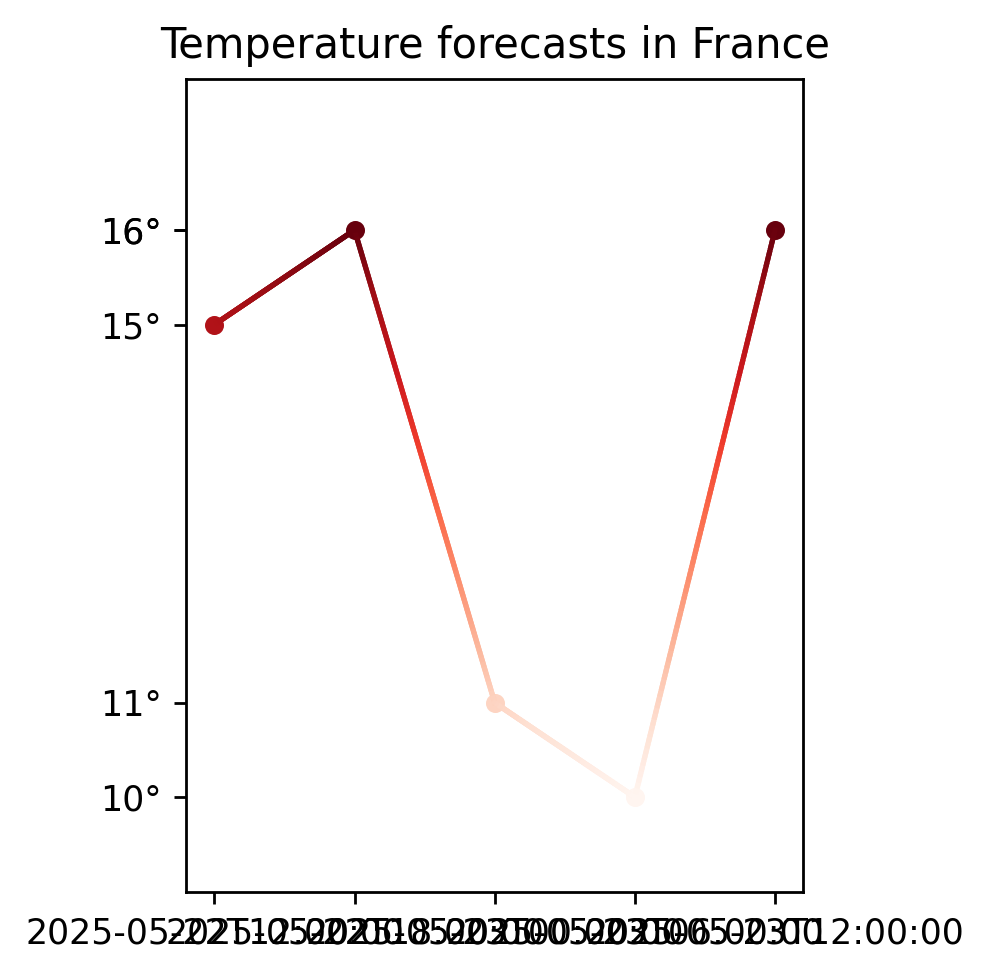

In [ ]:



#post_user_prompt ="Display the result on CairnFORM. Don't forget to include the result in your final answer. Format your final answer in Markdown."
post_user_prompt ="Display the result using the tool named 'cairnform_display_data'. Insert the resulting image in your final answer and format everything in Markdown."
# GUIDELINES
# 1. if the tool is not precise enough, add a few-shot example to the prompt
# 2. optimize tool to be as precise as possible (input parameters customization) to allow the LLM to get the data its needs (not less, not more).

# FRAMEWORK FOR DATA VIS FEATURES
# 1. plot
# 2. compare
# 3. filter
# 4. aggregate
# 5. sort
# 6. group
# 7. select
# 8. transform


# Miscellaneous Tasks
#user_input = "What time is it?"  # OK

## Live and forecast weather Tasks
# user_input = "What is the temperature in Paris right now?"  # OK
# user_input = "What is the humidity in Paris right now?"  # OK
# user_input = "What is the temperature in Bidart and in Bordeaux right now?"  # OK
# user_input = "How is the temperature, humidity, and wind in Bordeaux and Rennes right now?"  #  OK
# user_input = "How is the temperature in Bordeaux and Rennes tomorrow?"  #  OK
# user_input = "How is the temperature, humidity, and wind in Bordeaux and Rennes tomorrow?"  #  OK
# user_input = "What is the weather in France right now?"  # OK
#user_input = "What is the temperature in Paris in the next 5 days?"  # OK
user_input = "What is the temperature in France in the next 5 days?"  # ?
#user_input = "What is the weather in France in the next 5 days?"  # NOT OK

# Cryptocurrency Tasks
#user_input = "What is the price of Bitcoin and Ethereum right now?"  # OK


#user_input = "What is the wind speed in Bidart and Bordeaux?"  # (Ok for data fetch but not ok for CairnFORM)
#user_input = "What is the wind speed in Bidart and Bordeaux tomorrow?"  # (Ok for data fetch but not ok for CairnFORM)
user_prompt = f"{user_input}\n{post_user_prompt}"

# get context window size of the model
# context_window_size = llm.get_context_window_size()
# print("Context window size:", context_window_size)

# get the number of tokens in the prompt
ag = myAgent(llm, instructions, tools)
final_state = ag.invoke(user_prompt, verbose=True)
final_chat = ag.format_state_to_chat(final_state)
final_chat_messages = final_chat.to_messages()
for message in final_chat_messages:
    message.pretty_print()



In [ ]:
from IPython.display import display, Markdown
display(Markdown(final_state["output"]))

The temperature forecast for Paris over the next 5 days is as follows:

![Temperature Forecast in Paris](fig/7d4a163e-9157-4fee-89aa-57feae9af537.png)

In [ ]:
dataset = langfuse.get_dataset("Test")
 
for item in dataset.items:
    # Make sure your application function is decorated with @observe decorator to automatically link the trace
    with item.observe(
        run_name="first_run",
        run_description="My first run",
        run_metadata={"model": "mistral-small", "temperature": 0},
    ) as trace_id:
        # run your @observe() decorated application on the dataset item input
        #output = my_llm_application.run(item.input)
        agent_executor.invoke({"input": "What is the temperature in Bidart the day after tomorrow?", "chat_history": []}, config={"callbacks": [langfuse_handler]})
        # optionally, evaluate the output to compare different runs more easily
        langfuse.score(
            trace_id=trace_id,
            name="first_score",
            # any float value
            value= 1.0,#my_eval_fn(item.input, output, item.expected_output),
            comment="This is a comment",  # optional, useful to add reasoning
        )
 
# Flush the langfuse client to ensure all data is sent to the server at the end of the experiment run
langfuse.flush()

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Tuple, Any
set_verbose(True)
set_debug(False)

class AgentState(TypedDict):
    input: str
    chat_history: List[Tuple[str, str]]
    agent_scratchpad: List[Any]

builder = StateGraph(AgentState)

# Add steps (nodes)
builder.add_node("format_input", format_input_node)
builder.add_node("prompt", prompt_node)
builder.add_node("llm", llm_node)
builder.add_node("parse_output", output_parser_node)

# Connect the nodes
builder.set_entry_point("format_input")
builder.add_edge("format_input", "prompt")
builder.add_edge("prompt", "llm")
builder.add_edge("llm", "parse_output")
builder.set_finish_point("parse_output")

# Compile the graph
graph = builder.compile()

# Run it
result = graph.invoke({
    "input": "What is the current time?",
    "chat_history": [],
    "agent_scratchpad": []
})

In [ ]:
from langchain_ollama.chat_models import ChatOllama
llm = ChatOllama(model="mistral-small", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing Unit conversions on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
graph = builder.compile()

In [ ]:
from langchain_core.messages import HumanMessage
set_verbose(True)
set_debug(False)

messages = [
    HumanMessage(content="What is the current time? Display it on CairnFORM."),
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    msg.pretty_print()